<a href="https://colab.research.google.com/github/suri199507/image_processing_deep-learning/blob/master/object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Apr 27 06:12:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 5705 (delta 28), reused 38 (delta 15), pack-reused 5620
Receiving objects: 100% (5705/5705), 14.07 MiB | 14.76 MiB/s, done.
Resolving deltas: 100% (3798/3798), done.


In [3]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [4]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170901 sha256=5a413ae8dc649c911bdee4228375c08b70e7145b5eabc50085a64a287a3276a6
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=61511a66a716e4ca7be709a7f61a3ac8012ec81ec2fc3df8b0007ec9ab220a78
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [5]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [6]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 28kB/s 
     |████████████████████████████████| 450kB 35.8MB/s 
     |████████████████████████████████| 3.9MB 37.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=f1a442180ec1c748266cd13d80dc4ac0b991f0ee7a14ef343438db267b904758
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2

In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
!gdown --id 1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT --output indian_number_plates.json

Downloading...
From: https://drive.google.com/uc?id=1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT
To: /content/keras-retinanet/indian_number_plates.json
100% 92.5k/92.5k [00:00<00:00, 35.7MB/s]


In [0]:
os.makedirs("snapshots", exist_ok=True)

In [10]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:01, 152MB/s]


In [0]:
plates_df = pd.read_json('indian_number_plates.json', lines=True)

In [0]:
os.makedirs("number_plates", exist_ok=True)

In [13]:
dataset = dict()
dataset["image_name"] = list()
dataset["x_min"] = list()
dataset["y_min"] = list()
dataset["x_max"] = list()
dataset["y_max"] = list()
dataset["class_name"] = list()

counter = 0
for index, row in plates_df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save(f'number_plates/licensed_car_{counter}.jpeg', "JPEG")
    
    dataset["image_name"].append(f'number_plates/licensed_car_{counter}.jpeg')
    
    data = row["annotation"]
  
    width = data[0]["imageWidth"]
    height = data[0]["imageHeight"]

    dataset["x_min"].append(int(round(data[0]["points"][0]["x"] * width)))
    dataset["y_min"].append(int(round(data[0]["points"][0]["y"] * height)))
    dataset["x_max"].append(int(round(data[0]["points"][1]["x"] * width)))
    dataset["y_max"].append(int(round(data[0]["points"][1]["y"] * height)))
    dataset["class_name"].append("license_plate")
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.


In [14]:
df = pd.DataFrame(dataset)
df.head()

image_name  x_min  y_min  x_max  y_max     class_name
0  number_plates/licensed_car_0.jpeg    582    274    700    321  license_plate
1  number_plates/licensed_car_1.jpeg     80    382    288    449  license_plate
2  number_plates/licensed_car_2.jpeg     41    219    115    260  license_plate
3  number_plates/licensed_car_3.jpeg    217    313    359    359  license_plate
4  number_plates/licensed_car_4.jpeg    209    220    866    554  license_plate

In [0]:
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

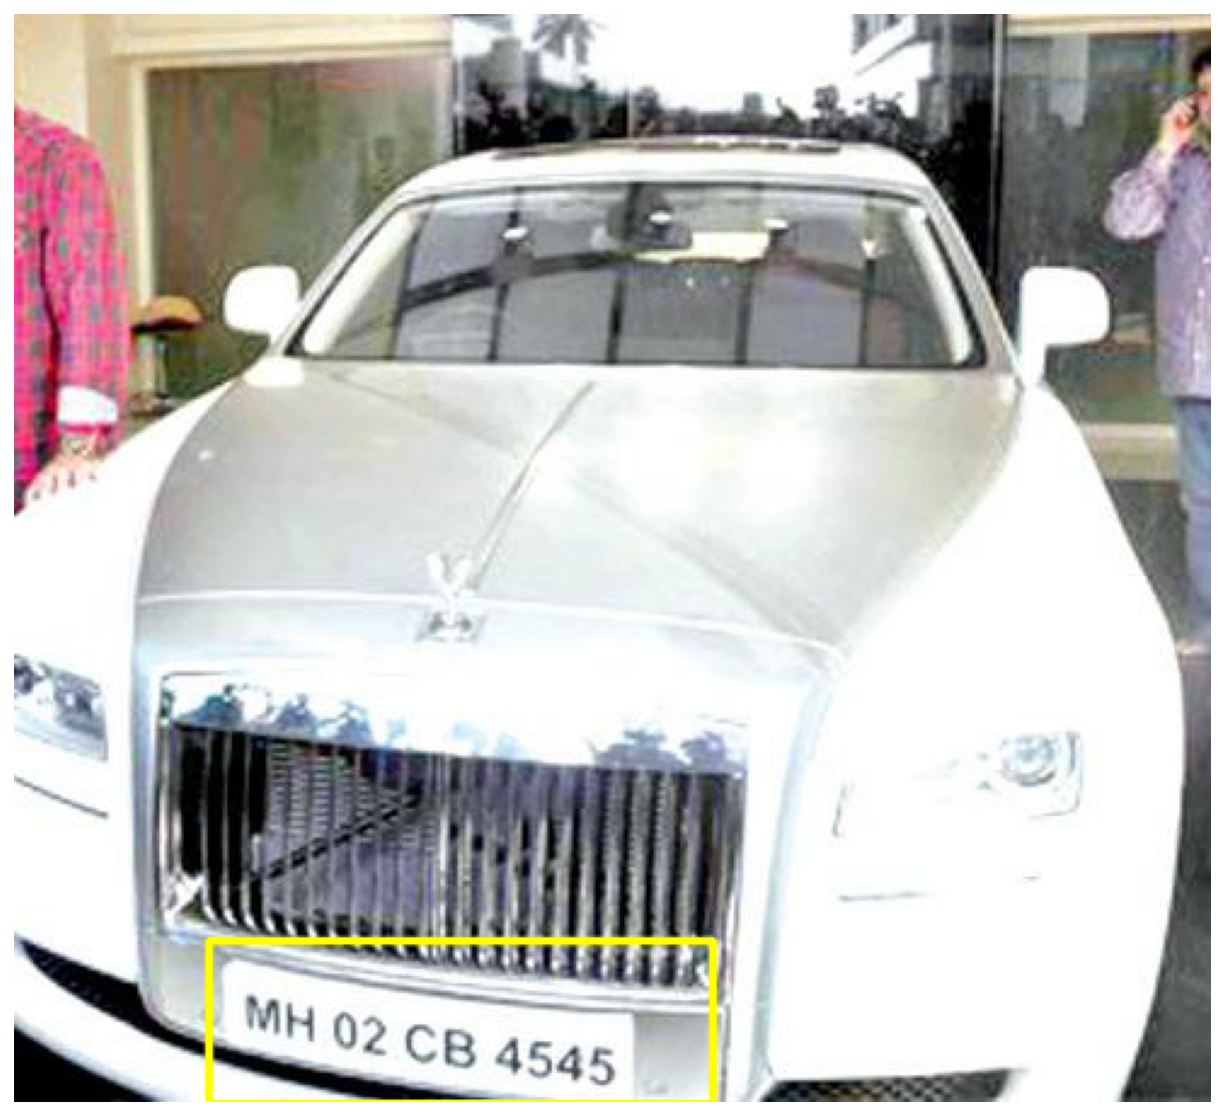

In [16]:
show_image_objects(df.iloc[1])

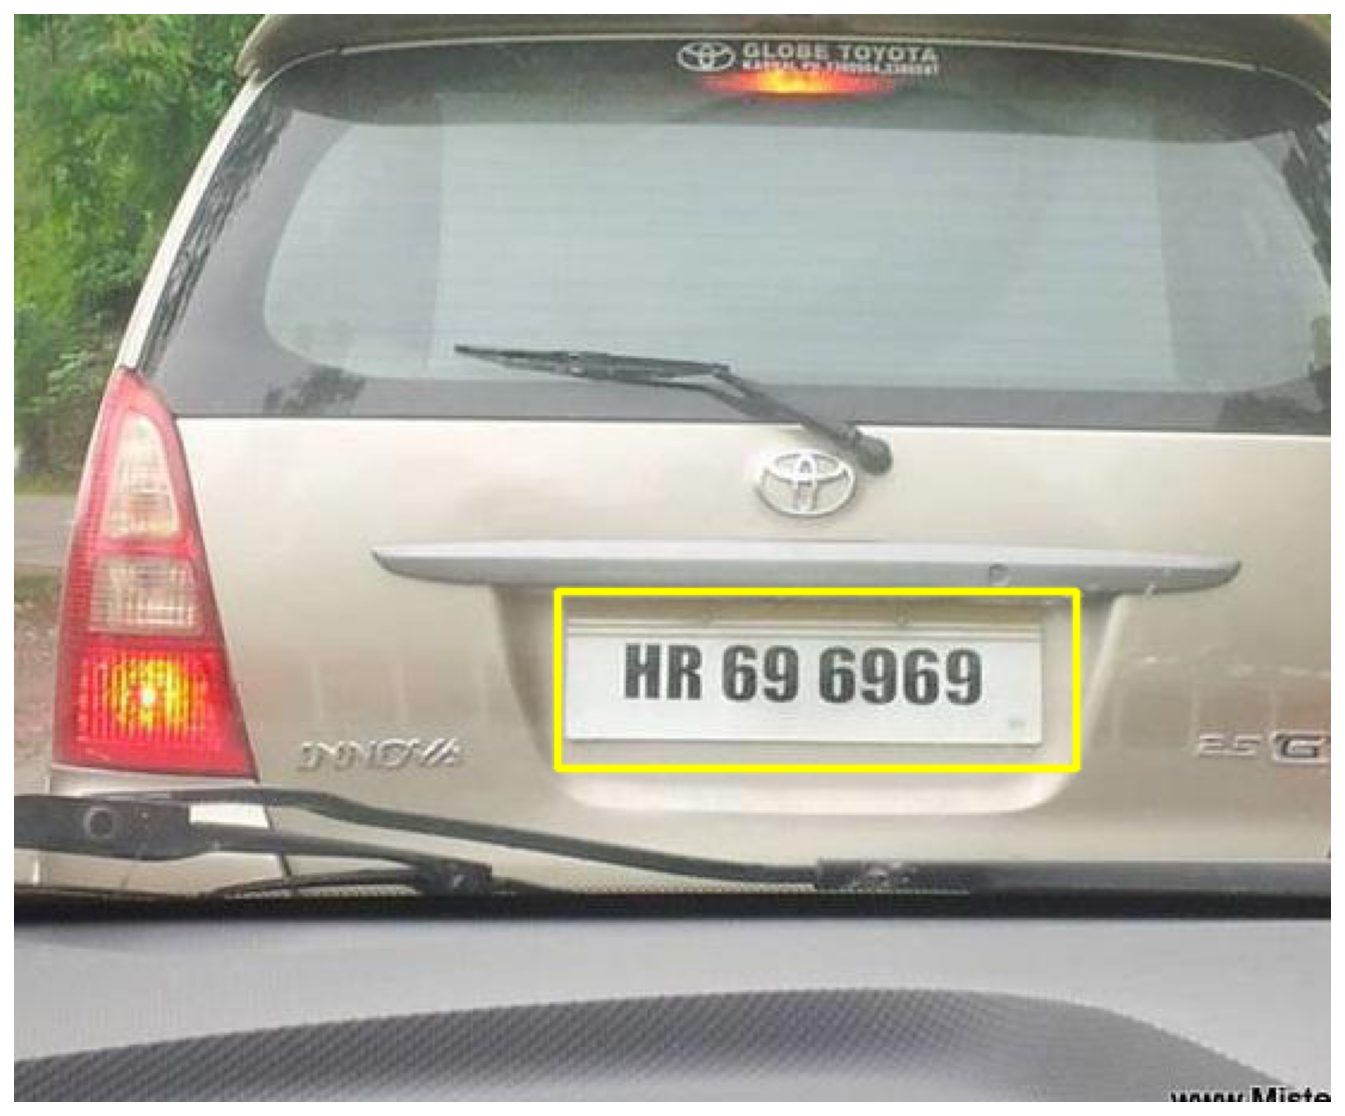

In [17]:
show_image_objects(df.iloc[6])

In [0]:
train_df, test_df = train_test_split(
  df, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

In [0]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [0]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [0]:
classes = set(['license_plate'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [22]:
!head classes.csv

license_plate,0


In [23]:
!head annotations.csv

number_plates/licensed_car_183.jpeg,169,260,358,298,license_plate
number_plates/licensed_car_201.jpeg,251,187,375,234,license_plate
number_plates/licensed_car_230.jpeg,140,149,324,220,license_plate
number_plates/licensed_car_95.jpeg,302,420,671,534,license_plate
number_plates/licensed_car_190.jpeg,115,86,227,117,license_plate
number_plates/licensed_car_84.jpeg,103,209,258,276,license_plate
number_plates/licensed_car_158.jpeg,83,34,369,483,license_plate
number_plates/licensed_car_97.jpeg,123,117,221,170,license_plate
number_plates/licensed_car_147.jpeg,162,227,312,274,license_plate
number_plates/licensed_car_184.jpeg,100,148,259,208,license_plate


In [24]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [25]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

Using TensorFlow backend.
2020-04-27 06:18:38.128356: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-27 06:18:38.128504: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2020-04-27 06:18:38.128530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Creating model, this may take a second...
2020-04-27 06:18:39.245374: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1


In [26]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_10.h5


In [27]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5


Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [0]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [0]:
THRES_SCORE = 0.6

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

In [0]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(255, 255, 0))

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [31]:
test_df.head(n=10)

image_name  x_min  ...  y_max     class_name
115  number_plates/licensed_car_115.jpeg     48  ...    188  license_plate
15    number_plates/licensed_car_15.jpeg    274  ...    431  license_plate
211  number_plates/licensed_car_211.jpeg    157  ...    160  license_plate
126  number_plates/licensed_car_126.jpeg    443  ...    347  license_plate
6      number_plates/licensed_car_6.jpeg    227  ...    315  license_plate
170  number_plates/licensed_car_170.jpeg    556  ...   1079  license_plate
9      number_plates/licensed_car_9.jpeg    674  ...    572  license_plate
221  number_plates/licensed_car_221.jpeg     93  ...    406  license_plate
112  number_plates/licensed_car_112.jpeg     22  ...    362  license_plate
220  number_plates/licensed_car_220.jpeg     55  ...    238  license_plate

[10 rows x 6 columns]

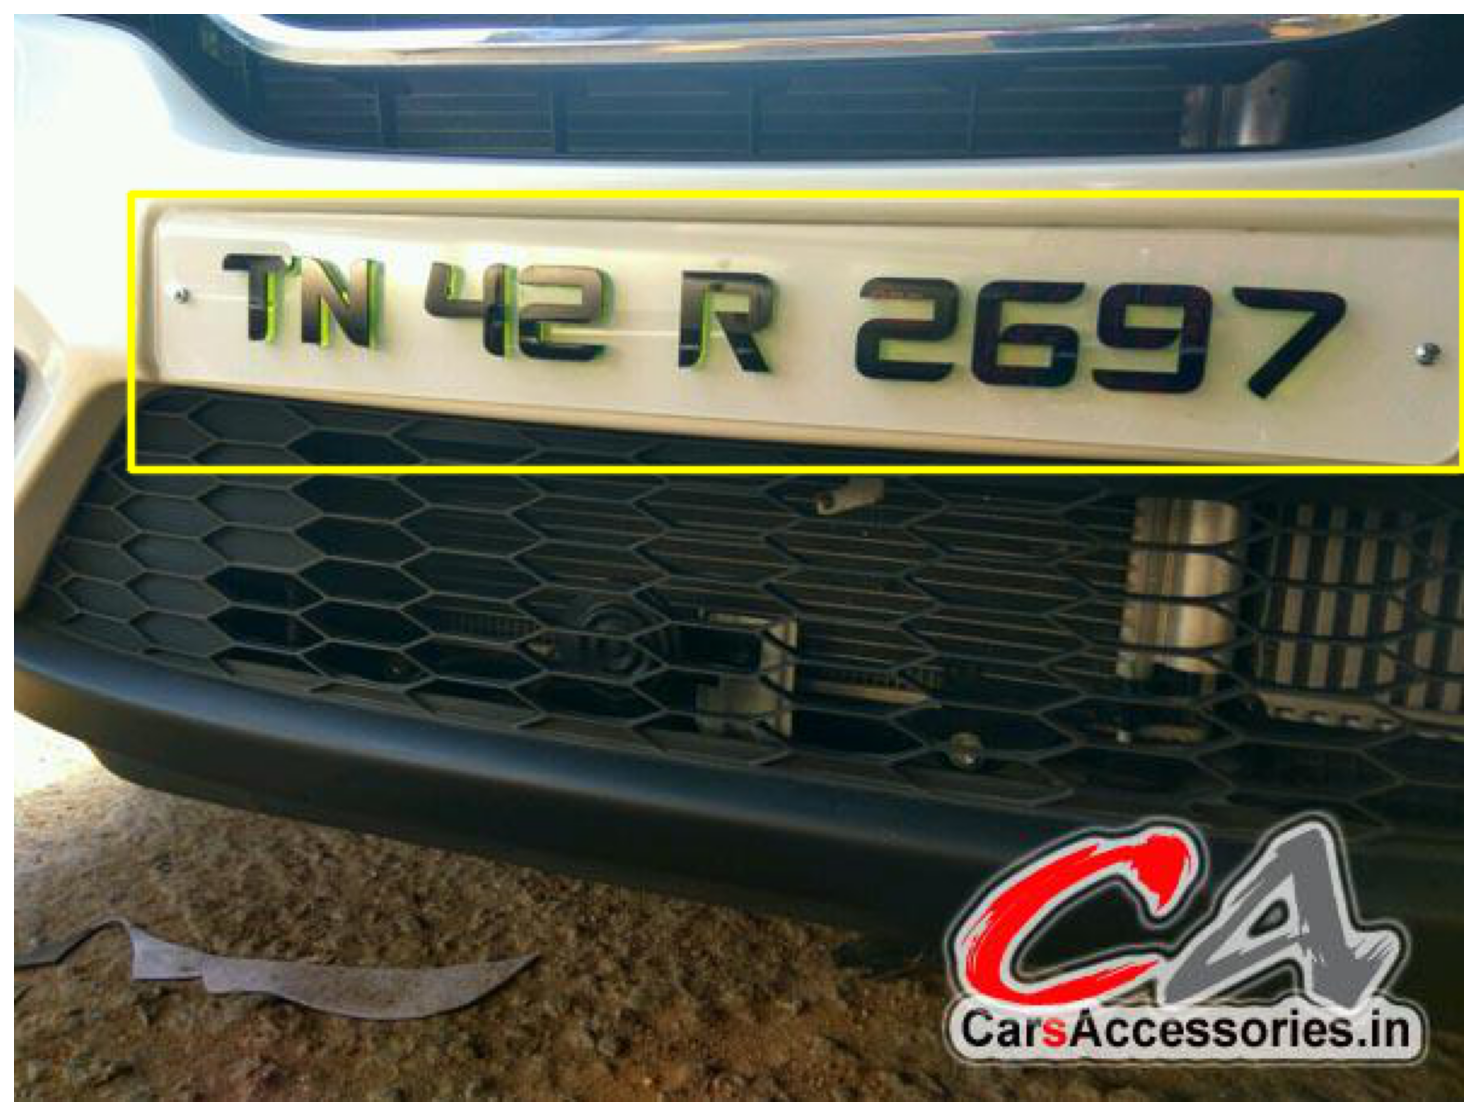

In [32]:
show_detected_objects(test_df.iloc[0])